In [31]:
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import os
from helpers import *
from preprocessing import *
import pickle
from neural_network_model import NeuralNetwork

In [2]:
#x_train, x_test, y_train, train_ids, test_ids=load_csv_data("data")

In [3]:
DATA_FOLDER = 'data/'

In [4]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
    with open(DATA_FOLDER + 'names_map.pickle', 'rb') as f:
        names_map = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)

    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)
    
    with open(DATA_FOLDER + 'names_map.pickle', 'wb') as f:
        pickle.dump(names_map, f)

## Preprocessing and Scalings

In [5]:
DATA_FOLDER = 'data/'

In [6]:
names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
names = np.delete(names, 0)
names_map = {}
for i in range(len(names)):
    names_map[names[i]] = i

In [7]:
y_train = np.where(y_train == -1, 0, y_train)
x_tr = x_train.copy()
y_tr = y_train.copy()


In [8]:
x_tr, x_val, y_tr, y_val = split_data(x_tr, y_tr, 0.8, seed=1)

In [9]:
#clean the data and return the cleaned dataset, the y values, the mean and median dictionaries to use to clean other sets (test set for example)
x_tr_clean, y_tr_clean, mean_dico, median_dico, interesting_features = clean_data(names_map, x_tr, y_tr, is_y=True, is_train_data=True)
x_val_clean, y_val_clean, _, _, _ = clean_data(names_map, x_val, y_val, is_y=True, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

#if we don't have the y values, we use is_y=False.
x_test_clean, _, _, _, _ = clean_data(names_map, x_test, y_raw=None, is_y=False, is_train_data=False, mean_dico=mean_dico, median_dico=median_dico)

In [10]:
np.where(y_tr_clean==1)[0].shape[0]/y_tr_clean.shape[0]

0.08880491261218705

In [11]:
np.where(y_val_clean==1)[0].shape[0]/y_val_clean.shape[0]

0.08629070352141649

## Feature selection

We chose some initial features by reading the report and assessing how they seemed relevant for our predictions.

In [12]:
interesting_features_indexes=np.array([names_map[feature] for feature in interesting_features])

In [13]:
X_train=x_tr_clean[:,interesting_features_indexes].copy()
X_validation = x_val_clean[:,interesting_features_indexes].copy()
X_test=x_test_clean[:,interesting_features_indexes].copy()

#### Build polynomial expension and interaction features

In [14]:
max_degree=3
interactions=False
X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=max_degree,interactions=interactions)
X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=max_degree,interactions=interactions)

In [15]:
X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
X_val_poly, _, _=scale_data(X_val_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)
X_test_poly,_,_=scale_data(X_test_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)

#### By correlation with the output

#### Again selecting features with correlation with the outcome y

In [16]:
correlations = np.corrcoef(np.hstack([X_train_poly, y_tr_clean.reshape(-1,1)]), rowvar=False)[:, X_train_poly.shape[1]][:-1]

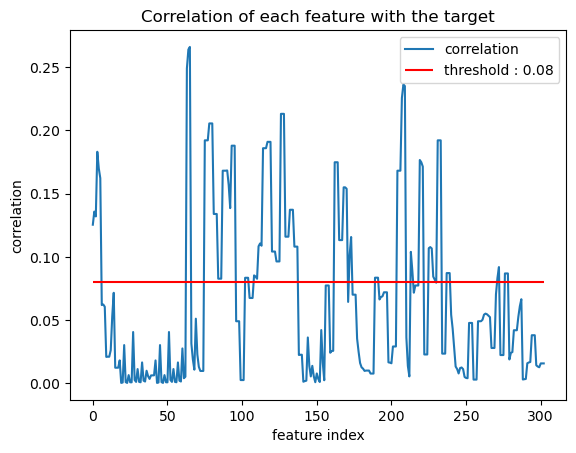

In [17]:
threshold = 0.08
plt.plot(np.abs(correlations))
plt.hlines(y=threshold, xmin=0, xmax=len(correlations) - 1, color='r')
plt.xlabel('feature index')
plt.ylabel('correlation')
plt.title('Correlation of each feature with the target')
plt.legend(['correlation', f"threshold : {threshold}"])
plt.show()

In [18]:
high_corr_indexes = np.where(correlations > threshold)[0]

In [19]:
high_corr_indexes.shape

(20,)

In [20]:
X_train_corr = X_train_poly[:, high_corr_indexes].copy()
X_val_corr = X_val_poly[:, high_corr_indexes].copy()

In [21]:
high_corr_features=list(np.array(features_names)[high_corr_indexes])
print(f"Features selected by high correlation with output (threshold)={threshold} : {len(high_corr_features)} features: \n {high_corr_features}")

Features selected by high correlation with output (threshold)=0.08 : 20 features: 
 ['POORHLTH**1', 'POORHLTH**2', 'POORHLTH**3', 'PHYSHLTH**1', 'PHYSHLTH**2', 'PHYSHLTH**3', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'JOINPAIN**2', 'JOINPAIN**3', '_AGEG5YR**1', '_AGEG5YR**2', '_AGEG5YR**3', '_RFCHOL**1', '_RFCHOL**2', '_RFCHOL**3', 'DRNKANY5**1', 'DRNKANY5**2', 'DRNKANY5**3']


#### Ridge regression

(0.44190871369294604, 0.03761257284125022, 0.0693246541903987)


c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:441: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


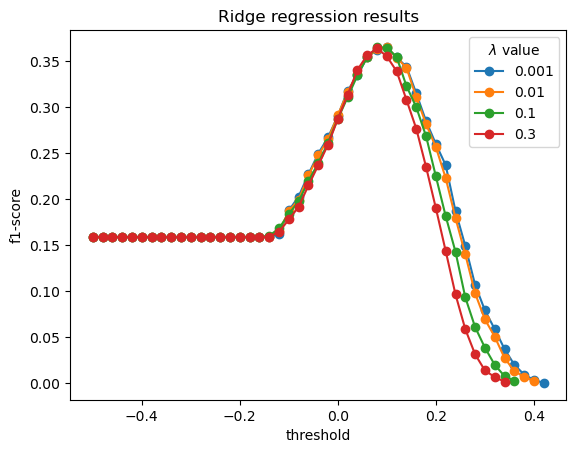

In [22]:
w_opt,loss=ridge_regression(y_tr_clean,X_train_corr,lambda_=0.01)
print(compute_scores_linear_model(X_val_corr,w_opt,y=y_val_clean,threshold=0.3,apply_sigmoid=False))
thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_train_corr,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_corr,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

#### Selection by ridge regression weight

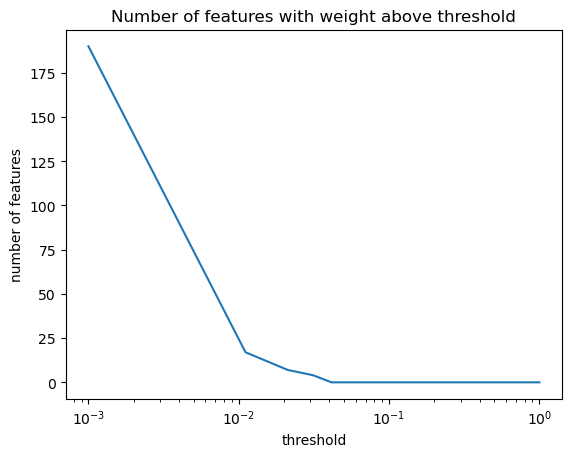

array([ 15,  16,  17,  37,  63,  64,  65,  78,  79,  80,  90,  92, 207,
       208, 209, 240, 241, 242, 244], dtype=int64)

In [23]:
w_opt_ridge,loss = ridge_regression(y_tr_clean,X_train_poly,lambda_=0.001)
filter_ = lambda x: np.where(np.abs(w_opt_ridge) > x)[0].shape[0]
x = np.linspace(0.001, 1, 100)
plt.plot(x, np.vectorize(filter_)(x))
plt.xscale('log')
plt.xlabel('threshold')
plt.ylabel('number of features')
plt.title('Number of features with weight above threshold')
plt.show()

np.where(np.abs(w_opt_ridge) > 0.01)[0]

In [24]:
high_weight_features=list(np.array(features_names)[np.where(np.abs(w_opt_ridge) > 0.01)[0]])
print(f"Features selected by ridge regression weight (threshold)={0.01} : {len(high_weight_features)} features : \n {high_weight_features}")

Features selected by ridge regression weight (threshold)=0.01 : 19 features : 
 ['HEIGHT3**1', 'HEIGHT3**2', 'HEIGHT3**3', 'EXERHMM1**2', 'GENHLTH**1', 'GENHLTH**2', 'GENHLTH**3', 'CVDSTRK3**1', 'CVDSTRK3**2', 'CVDSTRK3**3', 'DIABETE3**1', 'DIABETE3**3', '_AGEG5YR**1', '_AGEG5YR**2', '_AGEG5YR**3', '_BMI5**1', '_BMI5**2', '_BMI5**3', 'VIDFCLT2**2']


In [25]:
X_tr_ridge = X_train_poly[:, np.where(np.abs(w_opt_ridge) > 0.01)[0]].copy()
X_val_ridge = X_val_poly[:, np.where(np.abs(w_opt_ridge) > 0.01)[0]].copy()

Ridge regression results with selected features :

(0.515378221113882, 0.10948260639237153, 0.1806000582580833)


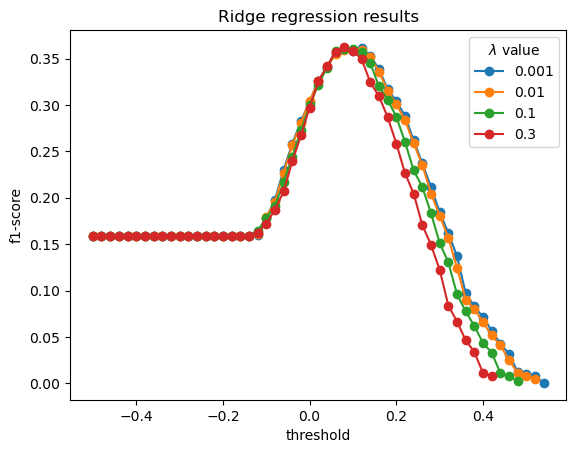

In [26]:
w_opt,loss=ridge_regression(y_tr_clean,X_tr_ridge,lambda_=0.01)
print(compute_scores_linear_model(X_val_ridge,w_opt,y=y_val_clean,threshold=0.3,apply_sigmoid=False))
thr_l=np.arange(-0.5,0.7,0.02)
for lambda_ in [0.001,0.01,0.1,0.3]:
    w_opt, loss =ridge_regression(y_tr_clean,X_tr_ridge,lambda_=lambda_)
    f1_scores=[compute_scores_linear_model(X_val_ridge,w_opt,y_val_clean,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

### Logistic regression

#### With features selected by ridge regression: 

(0.08629070352141649, 1.0, 0.15887221209145744)


c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:452: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


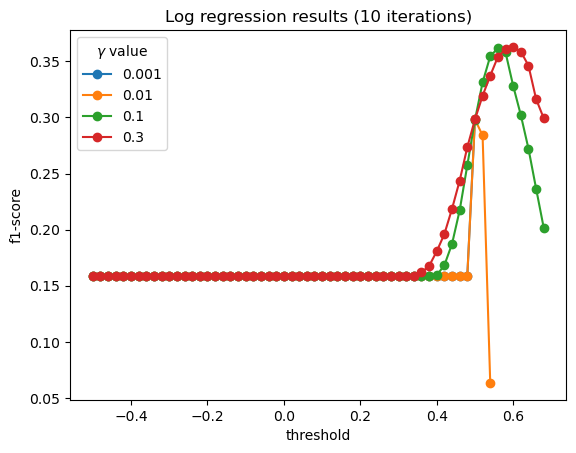

In [27]:
w_opt, loss = logistic_regression(y_tr_clean,X_tr_ridge,initial_w=np.zeros(X_tr_ridge.shape[1]),max_iters=10,gamma=0.01)
print(compute_scores_logistic_regression(X_val_ridge,w_opt,y=y_val_clean,threshold=0.3))
thr_l=np.arange(-0.5,0.7,0.02)
for gamma in [0.001,0.01,0.1,0.3]:
    w_opt, loss = logistic_regression(y_tr_clean,X_tr_ridge,initial_w=np.zeros(X_tr_ridge.shape[1]),max_iters=10,gamma=gamma)
    f1_scores=[compute_scores_logistic_regression(X_val_ridge,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.legend(title="$\\gamma$ value")
plt.title("Log regression results (10 iterations)")
plt.show()

#### With features selected by high correlation with output : 

c:\Users\Alexi\Documents\EPFL\M11\Machine Learning\P1\ml-project-1-whai\implementations.py:452: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


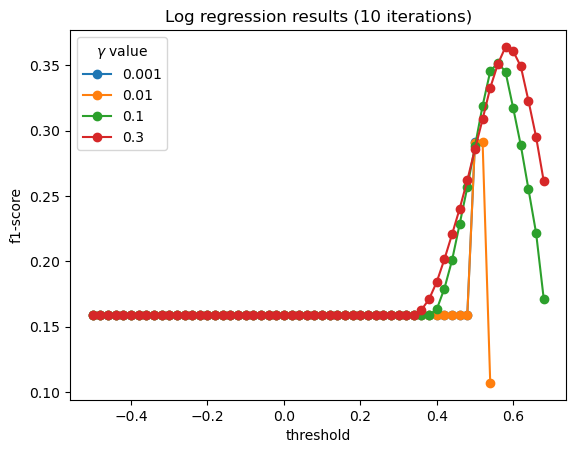

In [30]:
thr_l=np.arange(-0.5,0.7,0.02)
max_iters=15
for gamma in [0.001,0.01,0.1,0.3]:
    w_opt, loss = logistic_regression(y_tr_clean,X_train_corr,initial_w=np.zeros(X_train_corr.shape[1]),max_iters=max_iters,gamma=gamma)
    f1_scores=[compute_scores_logistic_regression(X_val_corr,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(gamma))
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.legend(title="$\\gamma$ value")
plt.title(f"Log regression results ({max_iters} iterations)")
plt.show()

### Neural Network

In [32]:
X_train_corr.shape

(262508, 20)

In [33]:
X_tr_ridge.shape

(262508, 19)

In [ ]:
input_size = X_train_corr.shape[1]
hidden_size = 2*int(len(X_train_corr.shape[0])*2/3)+1
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)
#model=MultLayerNN(layer_sizes=[input_size,int(hidden_size/2),int(hidden_size/2),output_size])
# Train the model
model.train(x_tra_scaled1, y_tra1.reshape(-1,1), epochs=1000,batching=True,batch_size=16)

##

### Cross validation & Grid search for parameter tuning

#### On whole X_train

In [28]:
%%time

k_fold = 5

losses_list = []
gen_losses_list = []

# split data in k fold
k_indices = build_k_indices(y_tr_clean.shape[0], k_fold, 42)

best_lambda_gammas = []
best_f1s = []

lambdas = [0.001, 0.005, 0.01]
gammas = [0.05, .1, .3]
lambda_gammas = [(lambdas[i], gammas[j]) for j in range(len(gammas)) for i in range(len(lambdas))]
degrees = [3]
max_iters = 5

for degree in degrees:
    X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=max_degree) 
    
    X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
    
    f1_degree = []
    for lambda_, gamma in lambda_gammas:
        print(f"degree: {degree}, lambda: {lambda_}, gamma: {gamma}")
        f1_l_g = []
        
        for k in range(k_fold):
            f1, _ = cross_validation(y_tr_clean, X_train_poly, k_indices, k, lambda_, gamma, max_iters, np.zeros(X_train_poly.shape[1]))
            f1_l_g.append(f1)
        f1_degree.append(np.mean(f1_l_g))

    ind_lambda_gamma_opt = np.argmax(f1_degree)
    best_lambda_gammas.append(lambda_gammas[ind_lambda_gamma_opt])
    best_f1s.append(f1_degree[ind_lambda_gamma_opt])

ind_best_degree = np.argmax(best_f1s)
best_degree = degrees[ind_best_degree]
best_lambda, best_gamma = best_lambda_gammas[ind_best_degree]
best_f1 = best_f1s[ind_best_degree]

print(f"Best degree: {best_degree}, best lambda: {best_lambda}, best gamma: {best_gamma}, best f1: {best_f1}")

KeyboardInterrupt: 

In [ ]:
X_train_poly,features_names=build_poly_expansion_with_interaction_features(X_train,features_names=interesting_features,max_degree=best_degree)
X_val_poly,_=build_poly_expansion_with_interaction_features(X_validation,features_names=interesting_features,max_degree=best_degree)
X_test_poly,_=build_poly_expansion_with_interaction_features(X_test,features_names=interesting_features,max_degree=best_degree)

X_train_poly, train_mean_poly, train_std_poly=scale_data(X_train_poly,is_train_data=True)
X_val_poly, _, _=scale_data(X_val_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)
X_test_poly,_,_=scale_data(X_test_poly,is_train_data=False,train_mean=train_mean_poly,train_std=train_std_poly)

w_opt, loss = reg_logistic_regression(y_tr_clean,X_train_poly,lambda_=best_lambda, initial_w=np.zeros(X_train_poly.shape[1]),max_iters=50,gamma=best_gamma)

thr_l=np.arange(0.2,0.9,0.02)
f1_scores=[compute_scores_logistic_regression(X_val_poly,w_opt,y_val_clean,threshold=t)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.title("Logistic regression results")
plt.show()


KeyboardInterrupt



In [ ]:
threshold = 0.6

print(compute_scores_logistic_regression(X_val_corr,w_opt,y=y_val_clean,threshold=threshold))

(0.2818181818181818, 0.5200423803637648, 0.36554335008998945)


In [ ]:
X_test_corr = X_test_poly[:, high_corr_indexes]

In [ ]:
y_pred = X_test_corr.dot(w_opt)
y_pred = np.where(y_pred > threshold, 1, -1)
create_csv_submission(test_ids, y_pred, 'submission-log-cor.csv')